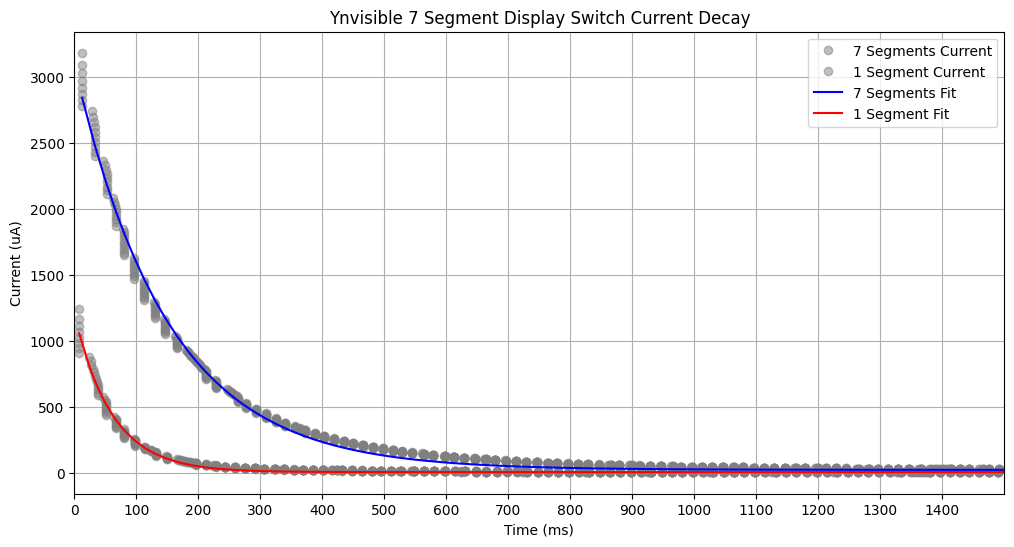

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Load the spreadsheet
file_path = '1vs7segs.xlsx'
xls = pd.ExcelFile(file_path)

# Load the data from the first sheet
df = pd.read_excel(xls, '1vs7segs')

# Clean up the DataFrame by renaming columns and removing the header row
df.columns = ['Time_7Seg', 'Current_7Seg', 'Time_1Seg', 'Current_1Seg']
df = df[1:]

# Convert the appropriate columns to numeric
df['Time_7Seg'] = pd.to_numeric(df['Time_7Seg'], errors='coerce')
df['Current_7Seg'] = pd.to_numeric(df['Current_7Seg'], errors='coerce')
df['Time_1Seg'] = pd.to_numeric(df['Time_1Seg'], errors='coerce')
df['Current_1Seg'] = pd.to_numeric(df['Current_1Seg'], errors='coerce')

# Convert units: Time to milliseconds and Current to microamperes
df['Time_7Seg'] *= 1000  # seconds to milliseconds
df['Current_7Seg'] *= 1e6  # amperes to microamperes
df['Time_1Seg'] *= 1000  # seconds to milliseconds
df['Current_1Seg'] *= 1e6  # amperes to microamperes

# Filter out rows with NaN values
df = df.dropna()

# Find the index of the maximum current value for each series
idx_max_7Seg = df['Current_7Seg'].idxmax()
idx_max_1Seg = df['Current_1Seg'].idxmax()

# Filter the data to keep only points after the maximum current value
filtered_7Seg = df.loc[idx_max_7Seg:]
filtered_1Seg = df.loc[idx_max_1Seg:]

# Define exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c


# Fit exponential decay to the 7 Segments series with adjusted initial guesses and without bounds to avoid infeasibility
initial_guess_7Seg = [filtered_7Seg['Current_7Seg'].max(), 0.001, filtered_7Seg['Current_7Seg'].min()]
params_7Seg, _ = curve_fit(exp_decay, filtered_7Seg['Time_7Seg'], filtered_7Seg['Current_7Seg'], p0=initial_guess_7Seg, maxfev=10000)

# Fit exponential decay to the 1 Segment series with adjusted initial guesses and without bounds to avoid infeasibility
initial_guess_1Seg = [filtered_1Seg['Current_1Seg'].max(), 0.001, filtered_1Seg['Current_1Seg'].min()]
params_1Seg, _ = curve_fit(exp_decay, filtered_1Seg['Time_1Seg'], filtered_1Seg['Current_1Seg'], p0=initial_guess_1Seg, maxfev=10000)

# Generate fitted values for plotting
fitted_7Seg = exp_decay(filtered_7Seg['Time_7Seg'], *params_7Seg)
fitted_1Seg = exp_decay(filtered_1Seg['Time_1Seg'], *params_1Seg)

# Plot the filtered current measurements with markers
plt.figure(figsize=(12, 6))
plt.plot(filtered_7Seg['Time_7Seg'], filtered_7Seg['Current_7Seg'], 'o', label='7 Segments Current', color='gray', alpha=0.5)
plt.plot(filtered_1Seg['Time_1Seg'], filtered_1Seg['Current_1Seg'], 'o', label='1 Segment Current', color='gray', alpha=0.5)

# Plot the fitted exponential decay lines
plt.plot(filtered_7Seg['Time_7Seg'], fitted_7Seg, '-', label='7 Segments Fit', color='blue')
plt.plot(filtered_1Seg['Time_1Seg'], fitted_1Seg, '-', label='1 Segment Fit', color='red')

plt.xlabel('Time (ms)')
plt.ylabel('Current (uA)')
plt.title('Ynvisible 7 Segment Display Switch Current Decay')
plt.legend()
plt.grid(True)
plt.xlim([0, 1500])
plt.xticks(np.arange(0, 1500, 100))
plt.show()


In [21]:
# Display the RC parameters for each series
print("7 Segments Fit Parameters:")
print(f"A (initial amplitude): {params_7Seg[0]:.2f} uA")
print(f"B (decay rate): {params_7Seg[1]:.6f} ms^-1")
print(f"C (offset): {params_7Seg[2]:.2f} uA")
print(f"Time Constant (tau): {1 / params_7Seg[1]:.2f} ms")
print()

print("1 Segment Fit Parameters:")
print(f"A (initial amplitude): {params_1Seg[0]:.2f} uA")
print(f"B (decay rate): {params_1Seg[1]:.6f} ms^-1")
print(f"C (offset): {params_1Seg[2]:.2f} uA")
print(f"Time Constant (tau): {1 / params_1Seg[1]:.2f} ms")

# Exponential decay function model
print("\nExponential Decay Model:")
print("The fitted model follows the equation:")
print("I(t) = A * exp(-B * t) + C")
print("\nWhere:")
print("I(t) is the current at time t (in microamperes)")
print("A is the initial amplitude (in microamperes)")
print("B is the decay rate (in ms^-1)")
print("C is the offset (in microamperes)")


7 Segments Fit Parameters:
A (initial amplitude): 3072.03 uA
B (decay rate): 0.006691 ms^-1
C (offset): 20.61 uA
Time Constant (tau): 149.45 ms

1 Segment Fit Parameters:
A (initial amplitude): 1196.19 uA
B (decay rate): 0.016506 ms^-1
C (offset): 3.55 uA
Time Constant (tau): 60.58 ms

Exponential Decay Model:
The fitted model follows the equation:
I(t) = A * exp(-B * t) + C

Where:
I(t) is the current at time t (in microamperes)
A is the initial amplitude (in microamperes)
B is the decay rate (in ms^-1)
C is the offset (in microamperes)


# Capacitor Size Calculation Based on Current Decay Model

We are given the empirically fitted current decay model:

$$
I(t) = 3072.03\,\mu\text{A} \times e^{-0.006691\,\text{ms}^{-1} \times t} + 20.61\,\mu\text{A}
$$

Our objective is to calculate the required capacitor size (\( C \)) to prevent the microcontroller from exceeding its current supply limit of 500 μA during the load peak.

## Given:

- **Microcontroller Supply Limit (\( I_{\text{max}} \))**: 500 μA
- **Current Decay Model**:

  $$
  I(t) = 3072.03\,\mu\text{A} \times e^{-0.006691\,\text{ms}^{-1} t} + 20.61\,\mu\text{A}
  $$

## Steps:

### 1. Define the Excess Current Supplied by the Capacitor (\( I_{\text{cap}}(t) \)):

The capacitor supplies the difference between the load current and the microcontroller's maximum current:

$$
I_{\text{cap}}(t) = I(t) - I_{\text{max}}
$$

### 2. Find the Time (\( t_1 \)) When \( I(t_1) = I_{\text{max}} \):

Set \( I(t_1) = 500\,\mu\text{A} \):

$$
\begin{align*}
500\,\mu\text{A} &= 3072.03\,\mu\text{A} \times e^{-0.006691\,\text{ms}^{-1} t_1} + 20.61\,\mu\text{A} \\
479.39\,\mu\text{A} &= 3072.03\,\mu\text{A} \times e^{-0.006691\,\text{ms}^{-1} t_1} \\
e^{-0.006691\,\text{ms}^{-1} t_1} &= \frac{479.39\,\mu\text{A}}{3072.03\,\mu\text{A}} \\
e^{-0.006691\,\text{ms}^{-1} t_1} &= 0.156 \\
-0.006691\,\text{ms}^{-1} t_1 &= \ln(0.156) \\
t_1 &= \frac{-\ln(0.156)}{0.006691\,\text{ms}^{-1}} \\
t_1 &\approx \frac{1.859}{0.006691} \\
t_1 &\approx 278.0\,\text{ms}
\end{align*}
$$

**So, the capacitor needs to supply current for approximately 278 ms.**

### 3. Calculate the Charge (\( Q \)) Required from the Capacitor:

The charge supplied by the capacitor is:

$$
Q = \int_{0}^{t_1} I_{\text{cap}}(t)\, dt
$$

Where:

$$
\begin{align*}
I_{\text{cap}}(t) &= I(t) - I_{\text{max}} \\
&= \left(3072.03\,\mu\text{A} \times e^{-0.006691\,\text{ms}^{-1} t} + 20.61\,\mu\text{A}\right) - 500\,\mu\text{A} \\
&= 3072.03\,\mu\text{A} \times e^{-0.006691\,\text{ms}^{-1} t} - 479.39\,\mu\text{A}
\end{align*}
$$

Compute the integral:

$$
\begin{align*}
Q &= \int_{0}^{278.0\,\text{ms}} \left[3072.03\,\mu\text{A} \times e^{-0.006691\,\text{ms}^{-1} t} - 479.39\,\mu\text{A}\right] dt \\
&= 3072.03\,\mu\text{A} \int_{0}^{278.0\,\text{ms}} e^{-0.006691\,\text{ms}^{-1} t} dt - 479.39\,\mu\text{A} \times 278.0\,\text{ms}
\end{align*}
$$

First integral:

$$
\int_{0}^{278.0\,\text{ms}} e^{-k t} dt = \left[ -\frac{1}{k} e^{-k t} \right]_{0}^{278.0\,\text{ms}}
$$

Where \( k = 0.006691\,\text{ms}^{-1} \):

$$
-\frac{1}{k} = -\frac{1}{0.006691\,\text{ms}^{-1}} = -149.47\,\text{ms}
$$

Evaluate at \( t = 278.0\,\text{ms} \) and \( t = 0 \):

$$
\begin{align*}
e^{-0.006691 \times 278.0} &= e^{-1.859} = 0.156 \\
e^{-0.006691 \times 0} &= e^{0} = 1
\end{align*}
$$

Compute the first integral:

$$
\begin{align*}
\text{First Integral} &= -149.47\,\text{ms} \times (e^{-0.006691 \times 278.0} - e^{0}) \\
&= -149.47\,\text{ms} \times (0.156 - 1) \\
&= -149.47\,\text{ms} \times (-0.844) \\
&= 126.18\,\text{ms}
\end{align*}
$$

Compute the first term:

$$
\text{First Term} = 3072.03\,\mu\text{A} \times 126.18\,\text{ms} = 387,628.78\,\mu\text{A} \cdot \text{ms}
$$

Compute the second term:

$$
\text{Second Term} = 479.39\,\mu\text{A} \times 278.0\,\text{ms} = 133,270.42\,\mu\text{A} \cdot \text{ms}
$$

Total charge (\( Q \)) supplied by the capacitor:

$$
\begin{align*}
Q &= \text{First Term} - \text{Second Term} \\
&= 387,628.78\,\mu\text{A} \cdot \text{ms} - 133,270.42\,\mu\text{A} \cdot \text{ms} \\
&= 254,358.36\,\mu\text{A} \cdot \text{ms}
\end{align*}
$$

Convert units:

Since \( 1\,\mu\text{A} \times 1\,\text{ms} = 1\,\text{nC} \):

$$
Q = 254,358.36\,\text{nC}
$$

### 4. Calculate the Required Capacitance (\( C \)):

Using \( Q = C \times \Delta V \), where \( \Delta V \) is the acceptable voltage droop (assume \( \Delta V = 0.1\,\text{V} \)):

$$
\begin{align*}
C &= \frac{Q}{\Delta V} \\
&= \frac{254,358.36\,\text{nC}}{0.1\,\text{V}} \\
&= 2,543,583.6\,\text{nF} \\
&= 2,543.58\,\mu\text{F}
\end{align*}
$$

---

## **Answer:**

You would need a capacitor of approximately **2,500 μF** to prevent the microcontroller from exceeding its current supply limits during the load peak, given your specific current decay model.



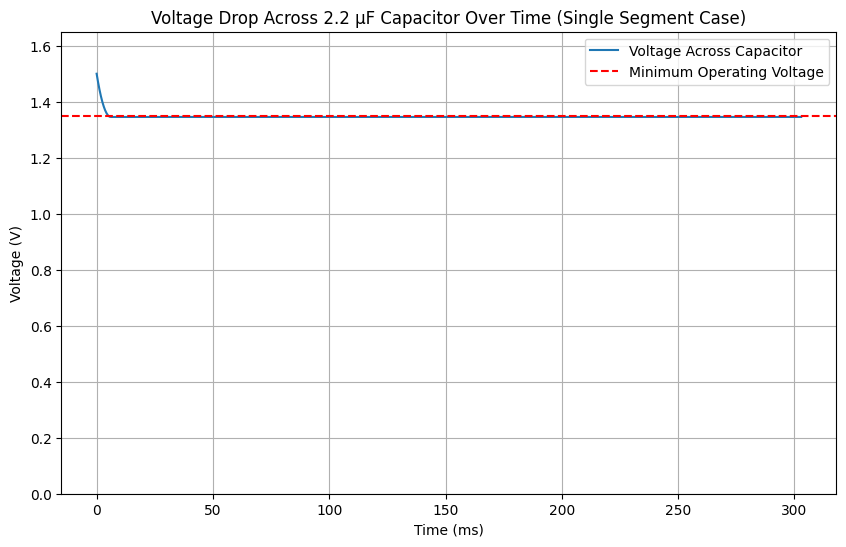

In [17]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define constants
C = 2.2e-6       # Capacitance in Farads (2.2 μF)
V0 = 1.5         # Initial voltage in Volts
I_max = 1100e-6   # Microcontroller supply limit in Amperes (500 μA)

# Current decay model parameters for single segment
I0 = 1196.19e-6  # Initial current in Amperes (1196.19 μA)
k = 0.016506     # Decay constant in ms^-1
I_min = 20.61e-6 # Minimum current in Amperes (20.61 μA)

# Time settings
tau = 1 / k          # Time constant in milliseconds
t_max = 5 * tau      # Total time for simulation (5 time constants)
t_points = 1000      # Number of time points
t = np.linspace(0, t_max, t_points)  # Time array in milliseconds

# Convert time to seconds for calculations
t_sec = t / 1000     # Convert ms to seconds

# Load current over time
I_load = I0 * np.exp(-k * t) + I_min  # Load current in Amperes

# Excess current drawn from the capacitor
I_cap = np.maximum(I_load - I_max, 0)  # Ensure I_cap >= 0

# Cumulative charge drawn from the capacitor
Q = np.cumsum(I_cap * np.diff(np.insert(t_sec, 0, 0)))  # Charge in Coulombs

# Voltage drop over time
V = V0 - Q / C  # Voltage across the capacitor

# Ensure voltage does not drop below zero
V = np.maximum(V, 0)

# Define minimum operating voltage (example value)
V_min_operating = 1.35  # Minimum voltage required for operation (adjust as needed)

# Plotting with additional features
plt.figure(figsize=(10, 6))
plt.plot(t, V, label='Voltage Across Capacitor')
plt.axhline(y=V_min_operating, color='r', linestyle='--', label='Minimum Operating Voltage')
plt.title('Voltage Drop Across 2.2 μF Capacitor Over Time (Single Segment Case)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.ylim(0, V0 * 1.1)
plt.legend()
plt.show()

